# This notebook computes "numerical J's": 
# the sensitivity functions of retracked parameters (Hs,z) to a localizd wave perturbation defined by (a,b) 

In [37]:
## Import packages
import numpy as np

from altimetry_waveforms_functions import *
import matplotlib.pyplot as plt
#import h5py
import matplotlib as mpl
mpl.rcParams.update({'figure.figsize':[10,6],'axes.grid' : True,'font.size': 14,'savefig.facecolor':'white'})


In [38]:
clight = 299792458
Rearth = 6378.1363*(10**3)

# --- satellite parameters ----------------------------
v_sat = 7*1e3 # satellite velocity in m/s
Altis = np.array([519*1e3, 781*1e3, 800*1e3, 891*1e3, 1340*1e3])
namesAltis = ['CFOSAT', 'SARAL', 'ENVISAT', 'SWOT', 'Jason3']
BW = np.array([(400*1e6),(500*1e6),(320*1e6),(320*1e6),(320*1e6)])
BX = np.array([(320*1e6),(500*1e6),(320*1e6),(320*1e6),(320*1e6)])
theta3dBs=np.array([(1.6),(0.61),(1.28),(1.28),(1.28)])*np.pi/180.

ialti = 4

theta3dB=theta3dBs[ialti]
alti_sat = Altis[ialti]
bandwidth = BW[ialti]       # bandwidth in Hz giving the time resolution of waveform (note that CFOSAT/SWIM is oversampled to a 400 MHz band)
bandx     = BX[ialti]       # real bandwidth in Hz 
nameSat = namesAltis[ialti]
tau=1E9/bandwidth           # time interval in nanoseconds
stonano=1000000000

dr = clight * 1/(2*bandwidth)


Hs=10.
sigs=0.25*Hs*2/clight*stonano               # sigma_s
Earth_sphericity_coef=(1+alti_sat/Rearth)   # 1+alti_sat/Rearth, 1 -> flat Earth 
nominal_tracking_gate=30
range_offset = (nominal_tracking_gate-1)*dr  # number of meters above nadir sea level included in waveform

nr=105
ranges = np.arange(0,(nr-1)*dr,dr) #-range_offset  


tax=1E9/bandx     # resolution in nanoseconds

rtot=(2./clight)*stonano  #Converts range to time
times=ranges*rtot
nr2=int(nr/2)
t0=tau*(nr2-1)
PTR=(np.sinc(np.pi*(times-t0)/tax))**2

s=sum(PTR)
PTR=PTR.T/s
noise=1E-3
PTM='True'
#PTR=[1]
timeshift=tau*nominal_tracking_gate
    

SWH_values = data["SWH_values"]
residual_std = data["residual_std"]
flag_edges = data["flag_edges"]
dr: 0.468425715625 size of weights array: (104, 21) 20
Wave height index selected: 20
WHALES indices: 22 82


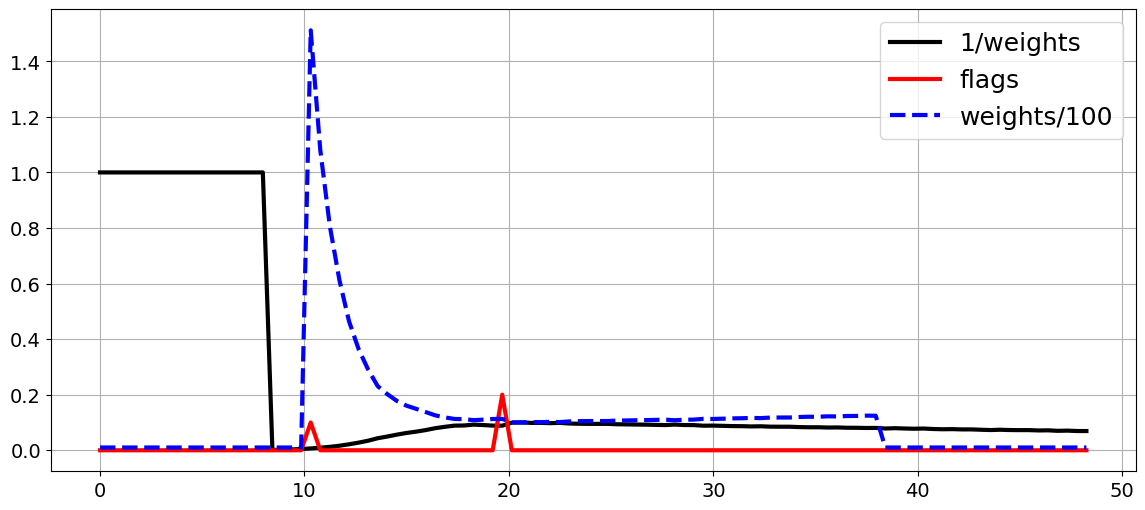

In [47]:
#mat_weights = h5py.File('weights.mat','r')
#weights=mat_weights['residual_tot'][:]
#flag_edges=mat_weights['flag_edges'][:]

data = np.load('weights/weights_J2.npz',allow_pickle=True)
for k in data.keys():
        print(k+' = data["'+k+'"]')
        exec(k+' = data["'+k+'"]')
       
#SWH_values=SWH_values,residual_std=residual_std,flag_edges=flag_edges)

weights=residual_std



SWH_yang=Hs
weigths_SWH_vector=np.arange(0,10.5,0.5)
select_weights=np.argmin(  np.abs(np.abs(SWH_yang)-weigths_SWH_vector)  )
 #Select the right line of weights
print('dr:',dr,'size of weights array:',np.shape(weights),select_weights)
this_weights=np.ones(nr-1)
weights_select=weights[:,ih]
print('Wave height index selected:',ih)
index_nanweights=np.where(np.isnan(weights_select))[0]
weights_select[index_nanweights]=1 #Transform the NaNs of the weight vector in ones


index_startweight=np.where(flag_edges[:,select_weights]==1)[0] #identify the start and the end of the leading edge in the weight vector
index_endweight=np.where(flag_edges[:,select_weights]==2)[0]
index_startweight=index_startweight[0] #convert array to index
index_endweight=index_endweight[0]+40  #convert array to index
gate1=22
this_weights[gate1:gate1+(index_endweight-index_startweight)]=weights_select[index_startweight:index_endweight]

this_weights=1./this_weights

print('WHALES indices:',gate1,gate1+(index_endweight-index_startweight))
      
fig,ax=plt.subplots(1,1,figsize=(14,6))
w2=3
line1=ax.plot(ranges[0:104],weights[:,select_weights],color='k',lw=w2,label='1/weights')
line2=ax.plot(ranges[0:104],0.1*flag_edges[:,20],color='r',lw=w2,label='flags')
line3=ax.plot(ranges[0:104],this_weights[0:104]/100,color='b',ls='dashed',lw=w2,label='weights/100')
plt.legend(loc='upper right', fontsize=18)



## Loops on b to compute J: this first part of the notebook using a 2 parameter erf waveform (flat trailing edge)

In [41]:
db=0.01;nb=int(2.01/db)+1
barray=np.arange(start=0, stop=2.01, step=db)
print(np.shape(barray),nb)
waveforms=np.zeros([1,nb,nr-1])
waveforms0=np.zeros([1,nb,nr-1])
waveforms2=np.zeros([1,nb,nr-1])
waveforms3=np.zeros([1,nb,nr-1])
waveforms4=np.zeros([1,nb,nr-1])

# Defines the amplitude of the regional wave height anomaly
a=0.2
#a=0.02



min_gate_rat=0.06


# loops on b (off-nadir distance where anomaly is located) 
for ib in range(nb):
    b=barray[ib]
    # Computes the perturbed waveform
    wf_fit1=wf_eval(ranges,np.array((0,Hs,1.,a,b)),clight,'wf_erf4D',PTR_model='True',PTR=PTR,noise=noise,alti_sat=alti_sat,\
                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB,Earth_sphericity_coef=Earth_sphericity_coef)
    waveforms2[0,ib,:]=wf_fit1[:]
    
m1=22 # this is the startgate for retracking
max_range_fit=42 #104 # this is stopgate in WHALES

print('Maximum waveform index used for retracking:',max_range_fit,'alti sat:',alti_sat)


#print('weights:',this_weights)
# Retracks all the waveforms with different retracking options     
Hs_1,ze_1,Pu,dar,R0r,di_1=retrack_waveforms(waveforms2,ranges,max_range_fit,clight,tau=tau,\
                        min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model='wf_erf2D',costfun='LS',mispointing=[0.],\
                        theta3dB=theta3dB,alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=m1,min_gate_rat=0.)

Hs_2,ze_2,Pu2,dar2,R0r2,di_2=retrack_waveforms(waveforms2,ranges,max_range_fit,clight,tau=tau,\
                        min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model='wf_erf2D',costfun='ML',mispointing=[0.],\
                        theta3dB=theta3dB,alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=m1,min_gate_rat=min_gate_rat)

from altimetry_waveforms_functions_new import *

Hs_3,ze_3,Pu,dar,R0r,di_3=retrack_waveforms_new(waveforms2,ranges,max_range_fit,clight,tau=tau,\
                        min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model='wf_erf2D',costfun='LS',weights=this_weights,mispointing=[0.],\
                        theta3dB=theta3dB,alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=m1,min_gate_rat=0.,nWHALES=0)




(201,) 201
Maximum waveform index used for retracking: 104 alti sat: 1340000.0
size of waveforms array: 1 201 104 alti_sat: 1340000.0
Estimated noise level: 0.0011182870919154671 93.75
Retracking waveforms 0  out of  1  ------------ 
size of waveforms array: 1 201 104 alti_sat: 1340000.0
Estimated noise level: 0.0011182870919154671 93.75
Retracking waveforms 0  out of  1  ------------ 
size of waveforms array: 1 201 104 alti_sat: 1340000.0
Estimated noise level: 0.0011182870919154671 93.75
Retracking waveforms 0  out of  1  ------------ 


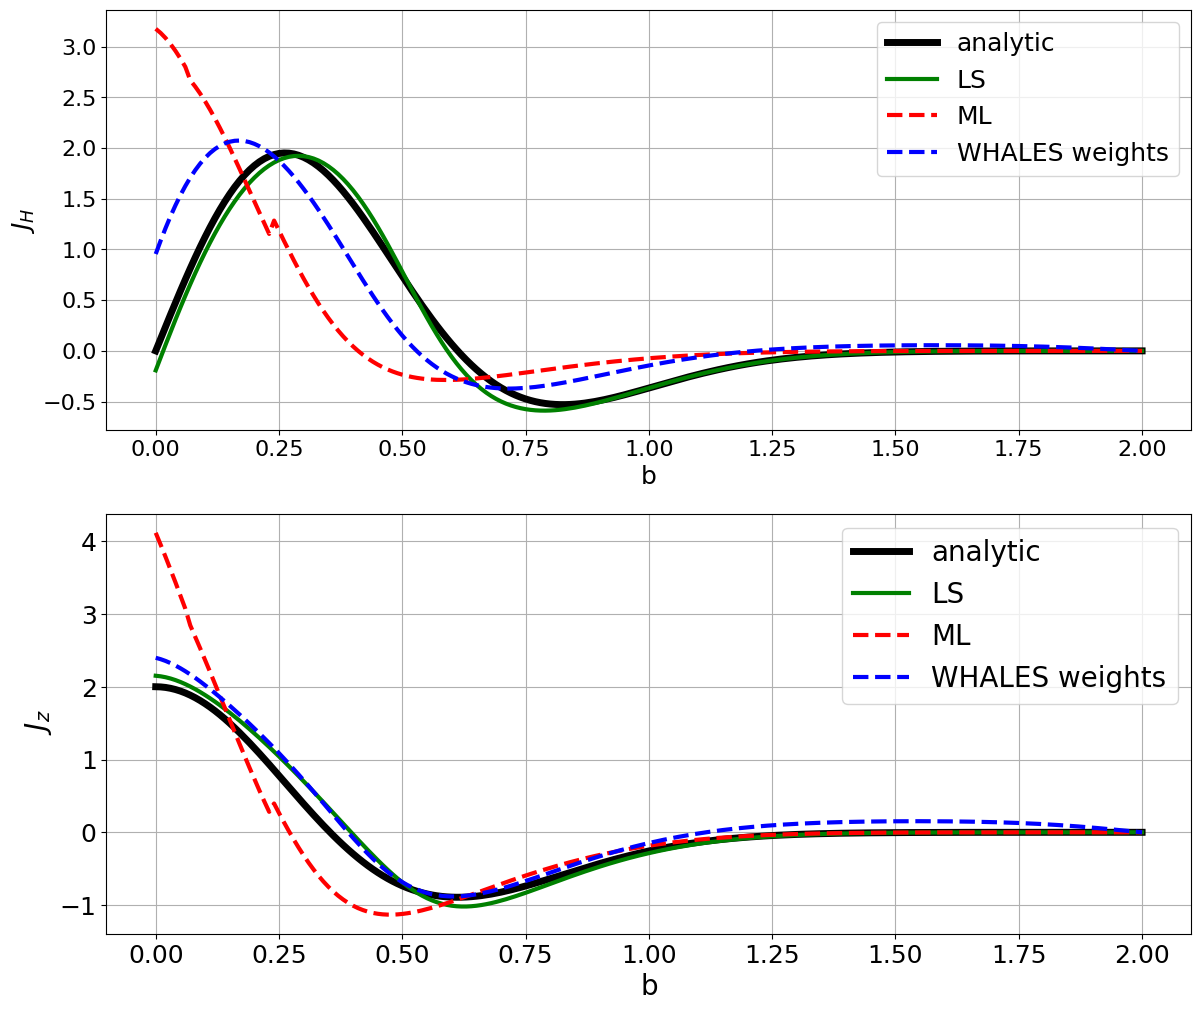

In [43]:
fig,axs=plt.subplots(2,1,figsize=(14,12))
ax=axs[0]
w1=5
w2=3
line1=ax.plot(barray,2*barray*(6- 16*barray**2)*np.exp(-4*barray**2),color='k',lw=w1,label='analytic')
line2=ax.plot(barray,2*(Hs_1.T-Hs_1[0,-1])/(a*Hs_1[0,-1]),color='g',lw=w2,label='LS')
line3=ax.plot(barray,2*(Hs_2.T-Hs_2[0,-1])/(a*Hs_2[0,-1]),color='r',linestyle='dashed',lw=w2,label='ML')
line4=ax.plot(barray,2*(Hs_3.T-Hs_3[0,-1])/(a*Hs_3[0,-1]),color='b',linestyle='dashed',lw=w2,label='WHALES weights')
ax.set_xlabel('b', fontsize=18)
ax.set_ylabel(r'$J_H$ ', fontsize=18)
leg = ax.legend(loc='upper right', fontsize=18)
ax.tick_params(axis='both', labelsize=16)
ax=axs[1]
line1=ax.plot(barray,(2- 16*barray**2)*np.exp(-4*barray**2),lw=w1,color='k',label='analytic')
line2=ax.plot(barray,16*(ze_1.T-ze_1[0,-1])/(a*Hs_1[0,-1]),color='g',lw=w2,label='LS')
line3=ax.plot(barray,16*(ze_2.T-ze_2[0,-1])/(a*Hs_2[0,-1]),color='r',lw=w2,linestyle='dashed',label='ML')
line4=ax.plot(barray,16*(ze_3.T-ze_3[0,-1])/(a*Hs_3[0,-1]),color='b',lw=w2,linestyle='dashed',label='WHALES weights')
#line2=ax.plot(ranges[min_range_fit:max_range_fit],wf_fit2[min_range_fit:max_range_fit]-wf_fit0[min_range_fit:max_range_fit],color='b',label='erf2D')
ax.set_xlabel('b', fontsize=20)
ax.set_ylabel(r' $J_z$', fontsize=20)
leg = ax.legend(loc='upper right', fontsize=20)
ax.tick_params(axis='both', labelsize=18)
fig.savefig('Js_for_a_0p20_WHALES_erf_notskewed.pdf')

meanJza=np.mean((2- 16*barray**2)*np.exp(-4*barray**2))



## Loops on b to compute J: this 2nd part of the notebook using a proper 3 parameter brown waveform 

In [51]:
db=0.01;nb=int(2.01/db)+1
barray=np.arange(start=0, stop=2.01, step=db)
print(np.shape(barray),nb)
waveforms=np.zeros([1,nb,nr-1])
waveforms0=np.zeros([1,nb,nr-1])
waveforms2=np.zeros([1,nb,nr-1])
waveforms3=np.zeros([1,nb,nr-1])
waveforms4=np.zeros([1,nb,nr-1])

# Defines the amplitude of the regional wave height anomaly
a=0.2
#a=0.02



min_gate_rat=0.06

wb=wf_eval(ranges,np.array((0,Hs,1.,0.,0.)),clight,'wf_brown',PTR_model='True',PTR=PTR,noise=noise,alti_sat=alti_sat,\
                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB,Earth_sphericity_coef=Earth_sphericity_coef)

# loops on b (off-nadir distance where anomaly is located) 
for ib in range(nb):
    b=barray[ib]
    wf_fit1=wf_eval(ranges,np.array((0,Hs,1.,a,b)),clight,'wf_bro4D',PTR_model='True',PTR=PTR,noise=noise,alti_sat=alti_sat,\
                            tau=tau,nominal_tracking_gate=nominal_tracking_gate,mispointing=0.,theta3dB=theta3dB,Earth_sphericity_coef=Earth_sphericity_coef)
    waveforms2[0,ib,:]=wf_fit1[:]
    
m1=1 # this is the startgate for retracking
max_range_fit=104 # this is stopgate in WHALES


m1=21 # this is the startgate for retracking
max_range_fit=82 #104 # this is stopgate in WHALES


print('Maximum waveform index used for retracking:',max_range_fit,'alti sat:',alti_sat,' m2:',ind2)


#print('weights:',this_weights)
# Retracks all the waveforms with different retracking options     
Hs_1,ze_1,Pu,dar,R0r,di_1=retrack_waveforms(waveforms2,ranges,max_range_fit,clight,tau=tau,\
                        min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model='wf_brown',costfun='LS',mispointing=[0.],\
                        theta3dB=theta3dB,alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=m1,min_gate_rat=0.)
                        #min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model='wf_erf2D',costfun='LS',mispointing=[0.],\
                        
Hs_2,ze_2,Pu2,dar2,R0r2,di_2=retrack_waveforms(waveforms2,ranges,max_range_fit,clight,tau=tau,\
                        min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model='wf_brown',costfun='ML',mispointing=[0.],\
                        theta3dB=theta3dB,alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=m1,min_gate_rat=min_gate_rat)

from altimetry_waveforms_functions_new import *

Hs_3,ze_3,Pu,dar,R0r,di_3=retrack_waveforms_new(waveforms2,ranges,max_range_fit,clight,tau=tau,\
                        min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model='wf_brown',costfun='LS',weights=this_weights,mispointing=[0.],\
                        theta3dB=theta3dB,alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=ind1,min_gate_rat=0.02,nWHALES=0)


# now takes a different weight ... squared
this_weights=1/wb**2
Hs_4,ze_4,Pu_4,dar_4,R0r,di_4=retrack_waveforms_new(waveforms,ranges,max_range_fit,clight,tau=tau,\
                        min_method='Nelder-Mead',PTR_model='True',PTR=PTR, wf_model='wf_brown',costfun='LS',weights=this_weights,mispointing=[0.],\
                        theta3dB=theta3dB,alti_sat=alti_sat,nominal_tracking_gate=nominal_tracking_gate,min_range_fit=m1,min_gate_rat=0.,nWHALES=0)



(201,) 201
Maximum waveform index used for retracking: 82 alti sat: 1340000.0  m2: 42
size of waveforms array: 1 201 104 alti_sat: 1340000.0
Estimated noise level: 0.0011114678915927364 93.75
Retracking waveforms 0  out of  1  ------------ 
size of waveforms array: 1 201 104 alti_sat: 1340000.0
Estimated noise level: 0.0011114678915927364 93.75
Retracking waveforms 0  out of  1  ------------ 
size of waveforms array: 1 201 104 alti_sat: 1340000.0
Estimated noise level: 0.0011114678915927364 93.75
Retracking waveforms 0  out of  1  ------------ 
size of waveforms array: 1 201 104 alti_sat: 1340000.0
Estimated noise level: 0.0 93.75
Retracking waveforms 0  out of  1  ------------ 


NameError: name 'Hs_4' is not defined

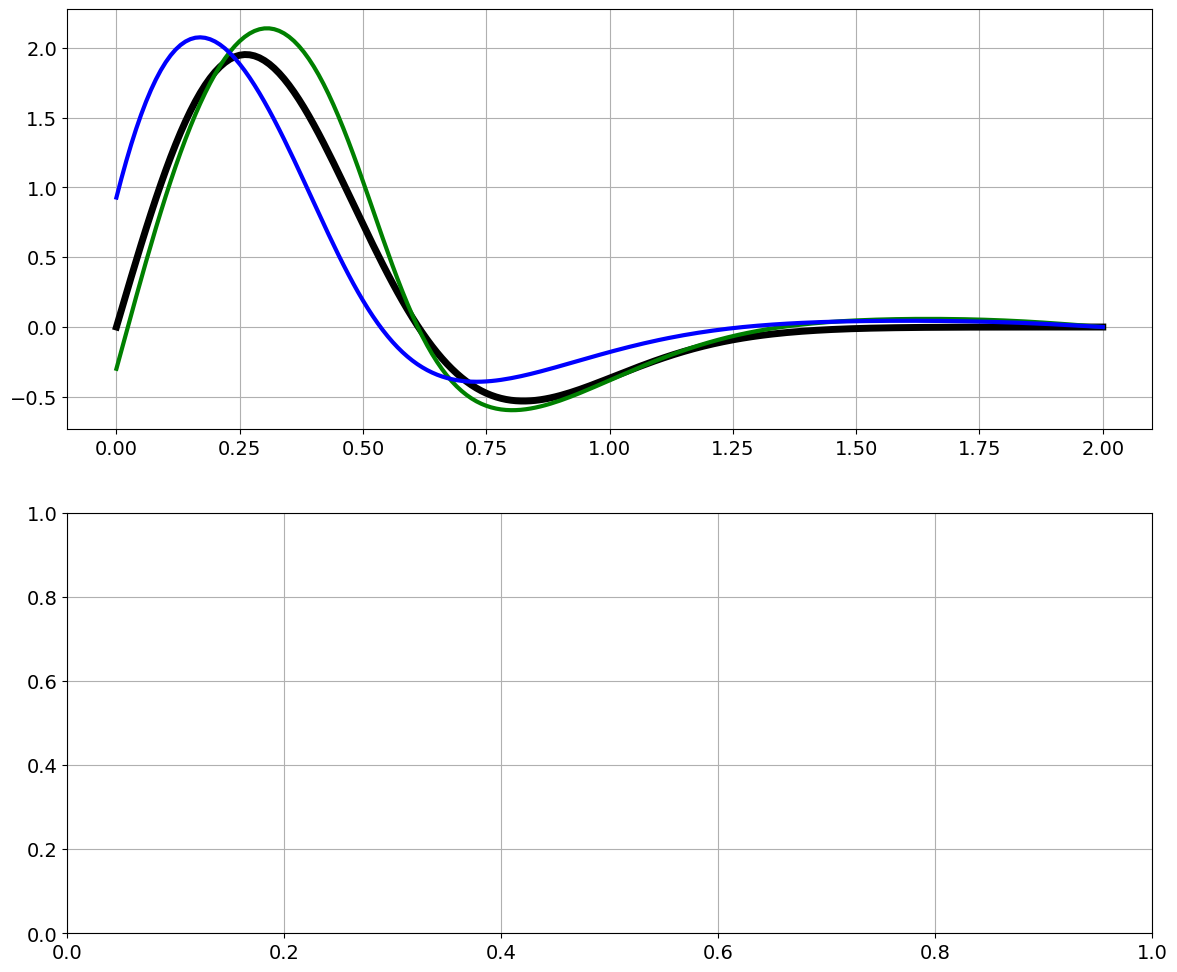

In [49]:
fig,axs=plt.subplots(2,1,figsize=(14,12))
ax=axs[0]
w1=5
w2=3
line1=ax.plot(barray,2*barray*(6- 16*barray**2)*np.exp(-4*barray**2),color='k',lw=w1,label='analytic')
line2=ax.plot(barray,2*(Hs_1.T-Hs_1[0,-1])/(a*Hs_1[0,-1]),color='g',lw=w2,label='LS')
#line3=ax.plot(barray,2*(Hs_2.T-Hs_2[0,-1])/(a*Hs_2[0,-1]),color='r',linestyle='dashed',lw=w2,label='ML')
line4=ax.plot(barray,2*(Hs_3.T-Hs_3[0,-1])/(a*Hs_3[0,-1]),color='b',lw=w2,label='WHALES  weights p(R)')
line4=ax.plot(barray,2*(Hs_4.T-Hs_4[0,-1])/(a*Hs_4[0,-1]),color='g',lw=w2,label='alternative weights p²(R)')
ax.set_xlabel(r'$b=r^2/(2 h H_s)$', fontsize=18)
ax.set_ylabel(r'$J_H$ ', fontsize=18)
leg = ax.legend(loc='upper right', fontsize=18)
ax.tick_params(axis='both', labelsize=16)
ax=axs[1]
line1=ax.plot(barray,(2- 16*barray**2)*np.exp(-4*barray**2),lw=w1,color='k',label='analytic')
line2=ax.plot(barray,16*(ze_1.T-ze_1[0,-1])/(a*Hs_1[0,-1]),color='g',lw=w2,label='LS')
line3=ax.plot(barray,16*(ze_2.T-ze_2[0,-1])/(a*Hs_2[0,-1]),color='r',lw=w2,linestyle='dashed',label='ML')
line4=ax.plot(barray,16*(ze_3.T-ze_3[0,-1])/(a*Hs_3[0,-1]),color='b',lw=w2,linestyle='dashed',label='WHALES  weights')
#line2=ax.plot(ranges[min_range_fit:max_range_fit],wf_fit2[min_range_fit:max_range_fit]-wf_fit0[min_range_fit:max_range_fit],color='b',label='erf2D')
ax.set_xlabel(r'$b=r^2/(26M20932429229  h H_s)$', fontsize=20)
ax.set_ylabel(r' $J_z$', fontsize=20)
leg = ax.legend(loc='upper right', fontsize=20)
ax.tick_params(axis='both', labelsize=18)
fig.savefig('Js_for_a_0p20_WHALES_brown_notskewed.pdf')

meanJza=np.mean((2- 16*barray**2)*np.exp(-4*barray**2))